# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

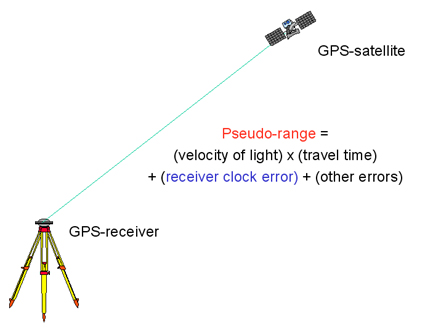

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [16]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [17]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [18]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [19]:
def euclidean_norm(receiver_pos, satellite_pos):

# Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [20]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    # Calculate the predicted pseudoranges
    predicted_pseudoranges = np.array(euclidean_norm(r_pos,s_pos)) + cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges

    # Sum of squared residuals
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [21]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric distances between receiver and each satellite
    geom_distances = euclidean_norm(s_pos, r_pos)

    # Predicted pseudoranges based on geometric distances and clock offset
    predicted_pseudoranges = geom_distances + cdT

    # Compute the residuals (differences between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudoranges

    # Partial derivatives of the cost function with respect to each receiver coordinate
    d_x_r = np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / geom_distances)
    d_y_r = np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / geom_distances)
    d_z_r = np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / geom_distances)

    # Partial derivative with respect to clock offset (cdT)
    d_cdT = np.sum(residuals)

    # Return the gradient as a 1D numpy array
    grad = np.array([d_x_r, d_y_r, d_z_r, d_cdT])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [22]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos,cdT,s_pos,pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos,cdT,s_pos,pseudorange)

        # update estimates
        # (1 mark)
        X_new = X + (learning_rate * grad)

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3],X_new[3],s_pos,pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [23]:

optimized_params = gradient_descent(pseudorange,sat_pos)
print(f"Optimized parameters receiver's: X:{optimized_params[0]}, Y:{optimized_params[1]}, Z:{optimized_params[2]}, cdT:{optimized_params[3]}\n")

# print the mentioned metrics

# Print Final Position errors of the receiver
print(f"Final Position error of the receiver: {arr_err[-1]}\n")

# Print number of steps taken for convergence
print(f"Number of steps taken for convergence: {steps_count}\n")

# Print final cost value
print(f"Final cost value: {arr_cost[-1]}\n")

# Print final gradient values
print(f"Final gradient values: {arr_grad[-1]}\n")


Converged !
Optimized parameters receiver's: X:-1633492.4442054832, Y:-3651629.5406444576, Z:4952485.427376054, cdT:6.4689908600397725

Final Position error of the receiver: [-3.06452823 -2.35814083  3.80782687]

Number of steps taken for convergence: 588

Final cost value: 6.197037218576748

Final gradient values: [-0.00011259 -0.00062736  0.00192816  0.0010931 ]



### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

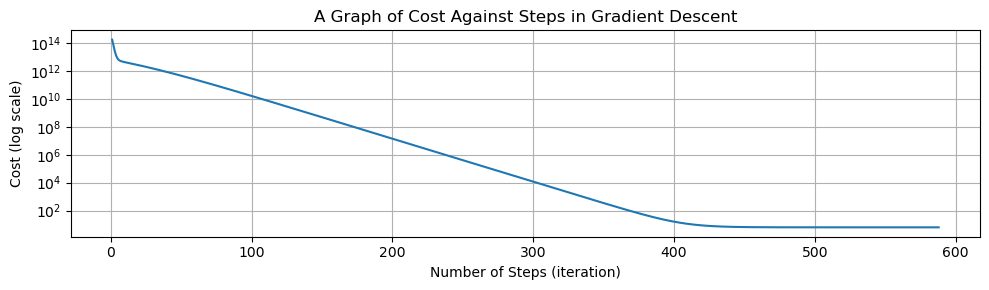

In [27]:
num_iter_list = np.arange(1, steps_count + 1)
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.semilogy(num_iter_list, arr_cost)  # Log scale on y-axis
ax.set_xlabel("Number of Steps (iteration)")
ax.set_ylabel("Cost (log scale)")
ax.set_title("A Graph of Cost Against Steps in Gradient Descent")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
#From the graph of Cost against Steps below, it can be oberved that at the initial step, 
# the cost (i.e difference between observed and predicted receiver's coodinate parameters)
#  was way too high. It experienced a steep drop at the first iteration. As iteration progresses,
#  the cost decreases. The decrease in the cost continued to be inversly proportional to the iteration
#  steps until it got to some point above 400 steps where it starts to flatten out. From 400 and above,
#  additional optimization steps adds little or no effect on the cost because it has been reduced to the 
# very minimum it can get. This explains the flattened line after 400+ iterations. At this point, the optimization
#  process is said to have converged.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

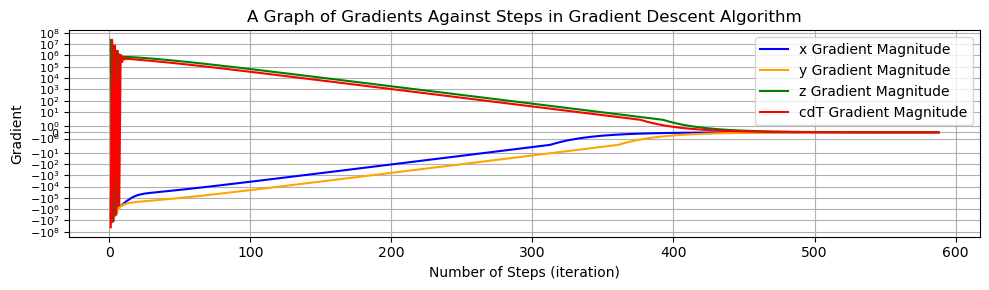

In [29]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

arr_grad = np.array(arr_grad)
# print(arr_grad)

# ax.plot(num_iter_list, arr_grad[:,0], label="X Gradient Magnitude" )
ax.plot(num_iter_list, arr_grad[:, 0], label="x Gradient Magnitude", color="blue")
ax.plot(num_iter_list, arr_grad[:, 1], label="y Gradient Magnitude", color="orange")
ax.plot(num_iter_list, arr_grad[:, 2], label="z Gradient Magnitude", color="green")
ax.plot(num_iter_list, arr_grad[:, 3], label="cdT Gradient Magnitude", color="red")
ax.set_yscale('symlog')  # Using symmetric log scale on the y-axis
ax.set_xlabel("Number of Steps (iteration)")
ax.set_ylabel("Gradient")
ax.set_title("A Graph of Gradients Against Steps in Gradient Descent Algorithm")
ax.legend()

# Setting tick parameters
ax.tick_params(axis='y', labelsize=8)

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot demonstrates an effective gradient descent process, with steep initial gradient reduction
#  followed by gradual convergence, indicating rapid early adjustments and fine-tuning near the optimal
#  solution, with varying convergence rates across variables.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

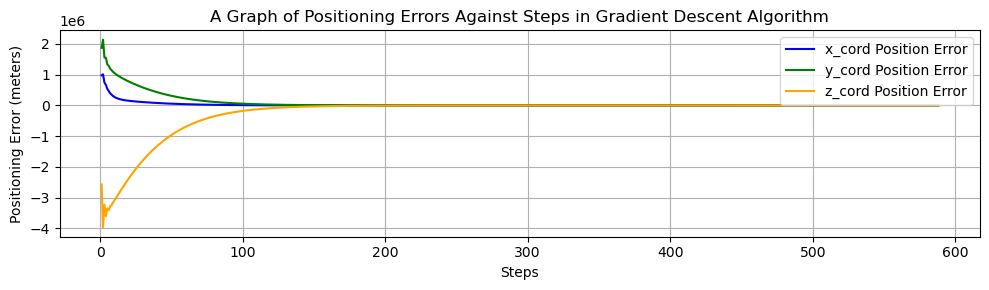

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

arr_err = np.array(arr_err)
ax.plot(num_iter_list, arr_err[:,0], label="x_cord Position Error", color="blue")
ax.plot(num_iter_list, arr_err[:,1], label="y_cord Position Error", color="green")
ax.plot(num_iter_list, arr_err[:,2], label="z_cord Position Error", color="orange")
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error (meters)")
ax.set_title("A Graph of Positioning Errors Against Steps in Gradient Descent Algorithm")
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows effective gradient descent optimization, with rapid error reduction in all coordinates 
# initially, followed by stabilization near zero, except for a minor residual error in the z-coordinate. 
# This pattern indicates successful convergence of the optimization process.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [31]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange,sat_pos,0.01,100000)

print(f"Optimized parameters: X:{optimized_params[0]}, Y:{optimized_params[1]}, Z:{optimized_params[2]}, cdT:{optimized_params[3]}\n")

# print the mentioned metrics

# Print Final Position errors of the receiver
print(f"Final Position error of the receiver: {arr_err[-1]}\n")

# Print number of steps taken for convergence
print(f"Number of steps taken for convergence: {steps_count}\n")

# Print final cost value
print(f"Final cost value: {arr_cost[-1]}\n")

# Print final gradient values
print(f"Final gradient values: {arr_grad[-1]}\n")

Converged !
Optimized parameters: X:-1633492.4442054832, Y:-3651629.5406444576, Z:4952485.427376054, cdT:6.4689908600397725

Final Position error of the receiver: [-3.06384888 -2.3543555   3.79619298]

Number of steps taken for convergence: 5652

Final cost value: 6.197166705529241

Final gradient values: [-0.00034695 -0.00193321  0.00594157  0.00336846]



In [32]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange,sat_pos,0.001,100000)

print(f"Optimized parameters: X:{optimized_params[0]}, Y:{optimized_params[1]}, Z:{optimized_params[2]}, cdT:{optimized_params[3]}\n")

# print the mentioned metrics

# Print Final Position errors of the receiver
print(f"Final Position error of the receiver: {arr_err[-1]}\n")

# Print number of steps taken for convergence
print(f"Number of steps taken for convergence: {steps_count}\n")

# Print final cost value
print(f"Final cost value: {arr_cost[-1]}\n")

# Print final gradient values
print(f"Final gradient values: {arr_grad[-1]}\n")

Converged !
Optimized parameters: X:-1633492.4442054832, Y:-3651629.5406444576, Z:4952485.427376054, cdT:6.4689908600397725

Final Position error of the receiver: [-3.06168702 -2.34230964  3.759171  ]

Number of steps taken for convergence: 53291

Final cost value: 6.198478264052894

Final gradient values: [-0.00110058 -0.00613234  0.01884729  0.01068509]



## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

QUESTION NUMBER ONE ANSWER:

From the results obstained after changing the learning from 0.1 to 0.01 and 0.001 respectively, it was observed that the gradient descent algorithm converged faster when the  learning rate was
 0.1, taking only 588 steps (iteration) to reach convergence. However, when the learning rate was reduced to 0.01, and 0.001 steps, the number of steps taken before convergence was 5652 steps for both learning rate. This shows that a higher learning rate converged faster compared to lower learning rate. This implies that lower learning rate leds to smaller adjustment per step, hence slowing down the convergence. Also, the receiver's positional coordinate errors gotten from the two lower learning rates (0.01 and 0.001) are slightly lower than that gotten from 0.1 learning rate. This indicates that, while the optimization step may be slower, it produces a slightly more refined result compared to the higher learning rate algorithm.

 QUESTION NUMBER TWO ANSWER

Both Least Square Estimation (LSE) and Gradient Descent are optimization processes. LSE is mainly used for linearized models (linear regression), and if the model is not linear, it will first be linearized before the optimization process begins. It optimizes the model by minimizing the sum of squared residuals (the difference between predicted and actual values).

Gradient descent on the other hand is a more robust optimization process that focuses on minimizing the value of the loss function by iteratively updating the model's parameters in the direction of the steepest descent. It can be used for both linear and nonlinear models, and there's no need for linearization of  complex models which leads to truncation of parameters.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---